<h1> Прогнозирование с помощью регрессии </h1>

In [1]:
#Импорт модулей 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle

from statsmodels.tsa.statespace import sarimax
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as lm
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Считываем и предобработанные данные

In [2]:
data = pd.read_csv('data_march-june.csv')
data =  data.append(data.iloc[-1], ignore_index=True) #костыль, т.к. не хватает одного последнего значения
data

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
0,14.0,22.0,20.0,39.0,78.0,124.0,183.0,193.0,212.0,31.0,...,4.0,0.0,1.0,105.0,16.0,59.0,20.0,146.0,12.0,120.0
1,16.0,15.0,12.0,12.0,58.0,60.0,98.0,122.0,144.0,14.0,...,5.0,0.0,2.0,5.0,1.0,33.0,9.0,71.0,6.0,23.0
2,4.0,14.0,0.0,9.0,23.0,55.0,59.0,93.0,162.0,21.0,...,10.0,1.0,0.0,0.0,0.0,1.0,0.0,18.0,0.0,0.0
3,2.0,7.0,1.0,4.0,16.0,35.0,39.0,63.0,119.0,11.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,1.0
4,5.0,16.0,2.0,8.0,30.0,31.0,25.0,44.0,79.0,4.0,...,7.0,0.0,0.0,4.0,1.0,0.0,0.0,34.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,104.0,142.0,149.0,141.0,333.0,368.0,390.0,385.0,560.0,247.0,...,1.0,27.0,7.0,288.0,344.0,103.0,24.0,209.0,145.0,0.0
2925,151.0,162.0,145.0,135.0,359.0,422.0,460.0,541.0,672.0,259.0,...,2.0,21.0,9.0,287.0,307.0,185.0,9.0,213.0,142.0,1.0
2926,106.0,168.0,103.0,125.0,317.0,476.0,405.0,508.0,578.0,259.0,...,3.0,19.0,5.0,358.0,387.0,169.0,12.0,206.0,146.0,0.0
2927,85.0,130.0,86.0,113.0,256.0,428.0,483.0,531.0,631.0,210.0,...,9.0,0.0,7.0,323.0,110.0,147.0,38.0,173.0,119.0,0.0


In [3]:
# Год и месяц начала и конца считывания данных (март-июнь)
START = datetime.datetime.strptime('2016-3','%Y-%m')
END = datetime.datetime.strptime('2016-7','%Y-%m')

# 1 мая разделяет обучающую и тестовую выборки
TT_SPLIT = datetime.datetime.strptime('2016-5','%Y-%m')

# 1 июня разделяет тестовую и отложенную выборки
TD_SPLIT = datetime.datetime.strptime('2016-6','%Y-%m')

# Функция для преобразования кол-ва часов от начала считывания в дату
def hour_to_datetime(hour):
    return START + datetime.timedelta(seconds=hour*3600)

# Функция для преобразования даты в кол-во часов от начала считывания
def date_to_hour(date):
    return int((date-START).total_seconds()/3600)

TT_SPLIT_HOUR = date_to_hour(TT_SPLIT) 
TD_SPLIT_HOUR = date_to_hour(TD_SPLIT)
CLUSTER_NUM = 5
REGIONS_NUM = 102

In [4]:
TT_SPLIT_HOUR, TD_SPLIT_HOUR-TT_SPLIT_HOUR

(1464, 744)

In [5]:
harmonic_estimation = pd.read_csv('harmonic_estimation.csv')#считывание гармонических признаков из предыдущего задания
clusters = pd.read_csv('clusters.csv') #считывание таблицы соответствия региона кластеру
cluster_centers = ['1233','1482','1333','1177','1441'] #регионы, являющиеся центрами кластеров
lambdas = pd.read_csv('lambdas.csv', index_col = 0) #параметры преобразования Бокса-Кокса

#Преобразование названия региона в его индекс в таблице
def region_to_index(reg):
    return data.columns.get_loc(reg)

#Номер кластера по названию региона
def get_cluster(reg):
    return clusters['0'][region_to_index(reg)]

# обрабтное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y)-1)
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda)-1)
    

#Обработка результата SARIMAX    
def interpret_SARIMAX_Result(x, reg):
    x = invboxcox(x, lambdas['0'][int(reg)])
    if x is np.nan or x<0: #заменяет отрицательные числа на 0, т.к. не может быть отрицательного числа поездок
        x = 0
    try:
        round(x)           #и округляет до ближайшего целого
    except ValueError:
        x=0
    return x

Создадим энкодеры для кодирования категориальных признаков

In [6]:
from sklearn import preprocessing
region_encoder = preprocessing.OneHotEncoder() #номер региона
region_encoder.fit(data.columns.to_numpy().reshape(-1, 1))

hour_encoder = preprocessing.OneHotEncoder() #час в сутках
hour_encoder.fit(np.array([hour_to_datetime(x).hour for x in range(24)]).reshape(-1, 1))

weekday_encoder = preprocessing.OneHotEncoder() #день недели
weekday_encoder.fit(np.array([hour_to_datetime(x).weekday() for x in range(0,192,24)]).reshape(-1, 1))

day_encoder = preprocessing.OneHotEncoder() #день месяца
day_encoder.fit(np.arange(1,32).reshape(-1, 1))

cluster_encoder = preprocessing.OneHotEncoder() #кластер
cluster_encoder.fit(np.arange(5).reshape(-1, 1))



OneHotEncoder()

<h3>Построение признаков</h3>

Будем для каждого региона строить большой датафрейм, содержащий максимальное кол-во признаков, и уже из него извлекать различные варианты выборок

In [7]:
SARIMAXResult = pd.read_csv('Result_1.csv')
SARIMAXResult

,id,y
0,1278_0,8.660613
1,1278_1,3.874283
2,1278_2,1.724350
3,1278_3,1.221460
4,1278_4,1.917667
...,...,...
298753,1733_2924,0.000000
298754,1733_2925,0.000000
298755,1733_2926,0.000000
298756,1733_2927,0.000000


In [8]:
K_MAX = 23
KD_MAX = 7
#Функция, строящая одну строку с признаками
def get_row(region,cluster,T):
    row = pd.Series()
    # получим значение datetime 
    date = hour_to_datetime(T)

   #строим предсказание
    '''if T<=TT_SPLIT_HOUR:
        exog = harmonic_estimation.iloc[T,cluster]
    else: 
        exog = harmonic_estimation.iloc[TT_SPLIT_HOUR:T+1,cluster]
    prediction = model.predict(start=T, end = T, exog = exog)'''
    try:
        prediction = SARIMAXResult[SARIMAXResult['id']=='{0}_{1}'.format(region,T)]['y'].values[0]
    except:
        print(region, T)
    # получим массив из k значений в предыдущие моменты времени
    autoreg = np.array(list(map(lambda ind: data[region][ind] if ind>=0 else data[region].mean(), 
                                range(T-K_MAX,T))))
    # получим массив из kd значений в предыдущие моменты*24 
    autoreg_24 = np.array(list(map(lambda ind: data[region][ind] if ind>=0 else data[region].mean(), 
                                range(T-KD_MAX*24,T,24))))
    # суммы за полдня, сутки, неделю и месяц
    half_day_sum =  np.sum(list(map(lambda ind: data[region][ind] if ind>=0 else data[region].mean(),
                                             range(T-12,T))))  
    day_sum =  np.sum(list(map(lambda ind: data[region][ind] if ind>=0 else data[region].mean(),
                                             range(T-24,T))))   
    week_sum =  np.sum(list(map(lambda ind: data[region][ind] if ind>=0 else data[region].mean(),
                                             range(T-24*7,T))))
    month_sum =  np.sum(list(map(lambda ind: data[region][ind] if ind>=0 else data[region].mean(),
                                             range(T-24*30,T))))

    # КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ
    row['region'] = region_encoder.transform(np.array(region).reshape(1, -1)).toarray()[0] #регион
    row['hour'] = hour_encoder.transform(np.array(date.hour).reshape(1, -1)).toarray()[0] #час суток
    row['weekday'] = weekday_encoder.transform(np.array(date.weekday()).reshape(1, -1)).toarray()[0] #день недели
    row['day'] = day_encoder.transform(np.array(date.day).reshape(1, -1)).toarray()[0] #день месяца
    row['cluster'] = cluster_encoder.transform(np.array(cluster).reshape(1, -1)).toarray()[0] #кластер
    # ВЕЩЕСТВЕННЫЕ ПРИЗНАКИ
    row['autoreg'] = autoreg #значения в предыдущие моменты времени
    row['autoreg_24'] = autoreg_24 #значения в предыдущие моменты*24
    row['target'] = data[region][T]
    row['datetime'] = hour_to_datetime(T)
    row['T'] = T #час от начала отсчета
    row['month'] = date.month #месяц
    row['harmonic'] = harmonic_estimation[str(cluster)][T] #гармонический признак
    row['SARIMAX'] = prediction #предсказание SARIMAX
    row['half_day_sum'] = half_day_sum # сумма за полдня
    row['day_sum'] = day_sum # сумма за сутки
    row['week_sum'] = week_sum # сумма за неделю 
    row['month_sum'] = month_sum # сумма за месяц
    return row
    
    

In [9]:
#Функция, стороящая большой датафрейм с признаками и целевой переменной
def build_dataset(region,start,end): 
    # получим значение кластера для данного региона
    cluster = get_cluster(region)
    #загрузим модель из файла
    #model = sarimax.SARIMAXResultsWrapper.load("models/region_{}.pickle.format(region))
    X = pd.DataFrame()
    #в цикле добавляем в датафрейм ряды
    for T in range(start,end):
        X = X.append(get_row(region,cluster,T),ignore_index = True)
    return X

In [10]:

# Функция, извлекающая необходимое количество признаков и целевую переменную из датафрейма в виде матрицы и вектора
def extract_feautures(k,kd,dt,redundant):
    X = np.hstack((np.stack(redundant['autoreg'].values)[:,:k],
                   np.stack(redundant['autoreg_24'].values)[:,:kd],
                   np.stack(redundant['region'].values),
                   np.stack(redundant['hour'].values),
                   np.stack(redundant['weekday'].values),
                   np.stack(redundant['day'].values),
                   np.stack(redundant['T'].values.reshape(-1,1)),
                   np.stack(redundant['month'].values.reshape(-1,1)),
                   np.roll(np.stack(redundant['harmonic'].values.reshape(-1,1)),-dt),
                   np.roll(np.stack(redundant['SARIMAX'].values.reshape(-1,1)),-dt),
                   np.stack(redundant['half_day_sum'].values.reshape(-1,1)),
                   np.stack(redundant['day_sum'].values.reshape(-1,1)),
                   np.stack(redundant['week_sum'].values.reshape(-1,1)),
                   np.stack(redundant['month_sum'].values.reshape(-1,1))))
    
    # шкалирование вещественных признаков
    #РЕЗУЛЬТАТ ПОЛУЧАЕТСЯ ЧУТЬ ХУЖЕ, ЕСЛИ ИСПОЛЬЗОВАТЬ ШКАЛИРОВАНИЕ
    #scl = StandardScaler(with_mean=False)
    #X = np.hstack((X[:,:-8],scl.fit_transform(X[:,-8:])))
    # сдвиг целевой переменной на необходимое значение
    y = np.roll(np.stack(redundant['target'].values),-dt)
    return X[:-dt],y[:-dt]

Проверим работу функций для одного конкретного региона.

In [10]:
S = build_dataset('1075',0,TD_SPLIT_HOUR)


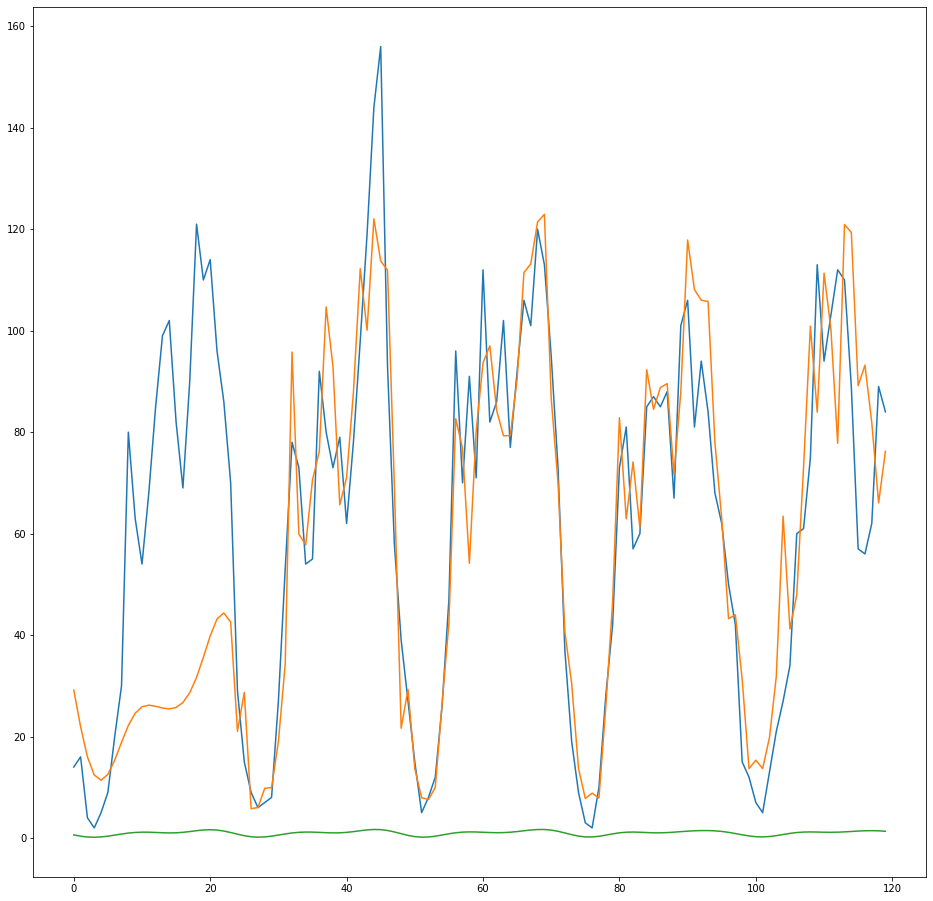

In [11]:
#Построим графики целевой переменной, предсказания авторегрессии и гармонического признака
plt.figure(figsize = (16,16))
plt.plot(S['target'][:120])
plt.plot(S['SARIMAX'][:120])
plt.plot(S['harmonic'][:120])

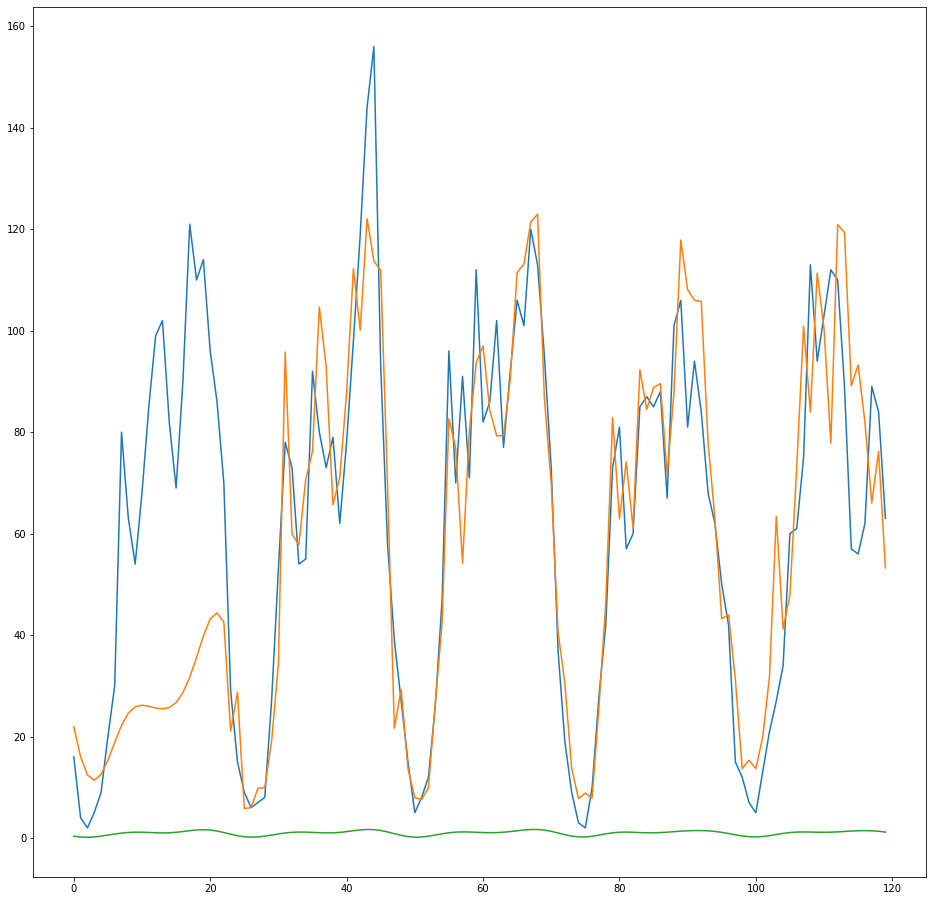

In [12]:
#То же самое, только теперь извлечем из датасета матрицу признаков и вектор целевой переменной, чтобы убедиться, что извлечение признаков работает
X,y = extract_feautures(1,1,1,S)
plt.figure(figsize = (16,16))
plt.plot(y[:120])
plt.plot(X[:120,-5])
plt.plot(X[:120,-6])

<h3>Поиск оптимальных моделей для каждого кластера</h3>

Как и в прошлом задании, будем отдельно подбирать параметры моделей для каждого кластера, построив признаки и обучив модели сперва для центров кластеров

In [14]:
#Все возможные признаки и целевая переменная для каждого центра кластера
redundant = [build_dataset(reg,0,TD_SPLIT_HOUR+1) for reg in cluster_centers]

In [15]:
# Фолд для использования в GridCV
train_indices = np.full((TT_SPLIT_HOUR,), -1, dtype=int)

test_indices = np.full((TD_SPLIT_HOUR-TT_SPLIT_HOUR,), 0, dtype=int)
test_fold = np.append(train_indices, test_indices)

from sklearn.model_selection import PredefinedSplit
ps = PredefinedSplit(test_fold)

# Сетка параметров для использования в GridCV
parameters_grid = {
    'normalize' : [True, False],
    'alpha' : np.linspace(0.0001, 5.0, num = 10),
}

# Оптимизация будет по тому же критерию, по которому будет считаться ошибка в итоге
def abs_loss(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred))

from sklearn.metrics import  make_scorer
score = make_scorer(abs_loss, greater_is_better=False)

Подберем оптимальные модели для центра каждого кластера, используя перебор по сетке параметров, перебор нескольких регрессоров и перебор по различным количествам авторегрессионных признаков (k и kd). Будем обучать на выборке до мая и сравнивать по абсолютной ошибке на майской выборке

In [16]:


results = [pd.DataFrame() for c in range(CLUSTER_NUM)] # Здесь будут результаты перебора
grids = [] # GridCV для каждого кластера

kd_pool = [0,1,2,5,7] # варианты значений kd
k_pool = [0,1,2,4,6,8,10,14,18,23] # варианты значений k

for cluster in range(CLUSTER_NUM):
    for kd in kd_pool:
        for k in k_pool:
            # Получаем необходимые признаки
            X,y = extract_feautures(k,kd,1,redundant[cluster]) 
            # разбиваем на обучающую и тестовую выборки
            X_train, X_test, _ = np.array_split(X, [TT_SPLIT_HOUR,TD_SPLIT_HOUR])
            y_train, y_test, _ = np.array_split(y, [TT_SPLIT_HOUR,TD_SPLIT_HOUR])
            # варианты регрессоров
            models_pool = [lm.Lasso(),lm.Ridge(),lm.ElasticNet(),lm.LassoLars()]
            grids.append([GridSearchCV(model, parameters_grid,scoring = score,cv = ps) for model in models_pool])
            # обучаем GridCV для каждого кластера
            for grid in grids[-1]:
                grid.fit(X[:TD_SPLIT_HOUR,:],y[:TD_SPLIT_HOUR])
            # записываем полученную ошибку     
            row = pd.Series()
            for i,grid in enumerate(grids[-1]):
                row[str(i)] = abs_loss(y_test,grid.best_estimator_.predict(X_test))           
            results[cluster] = results[cluster].append(row, ignore_index = True)

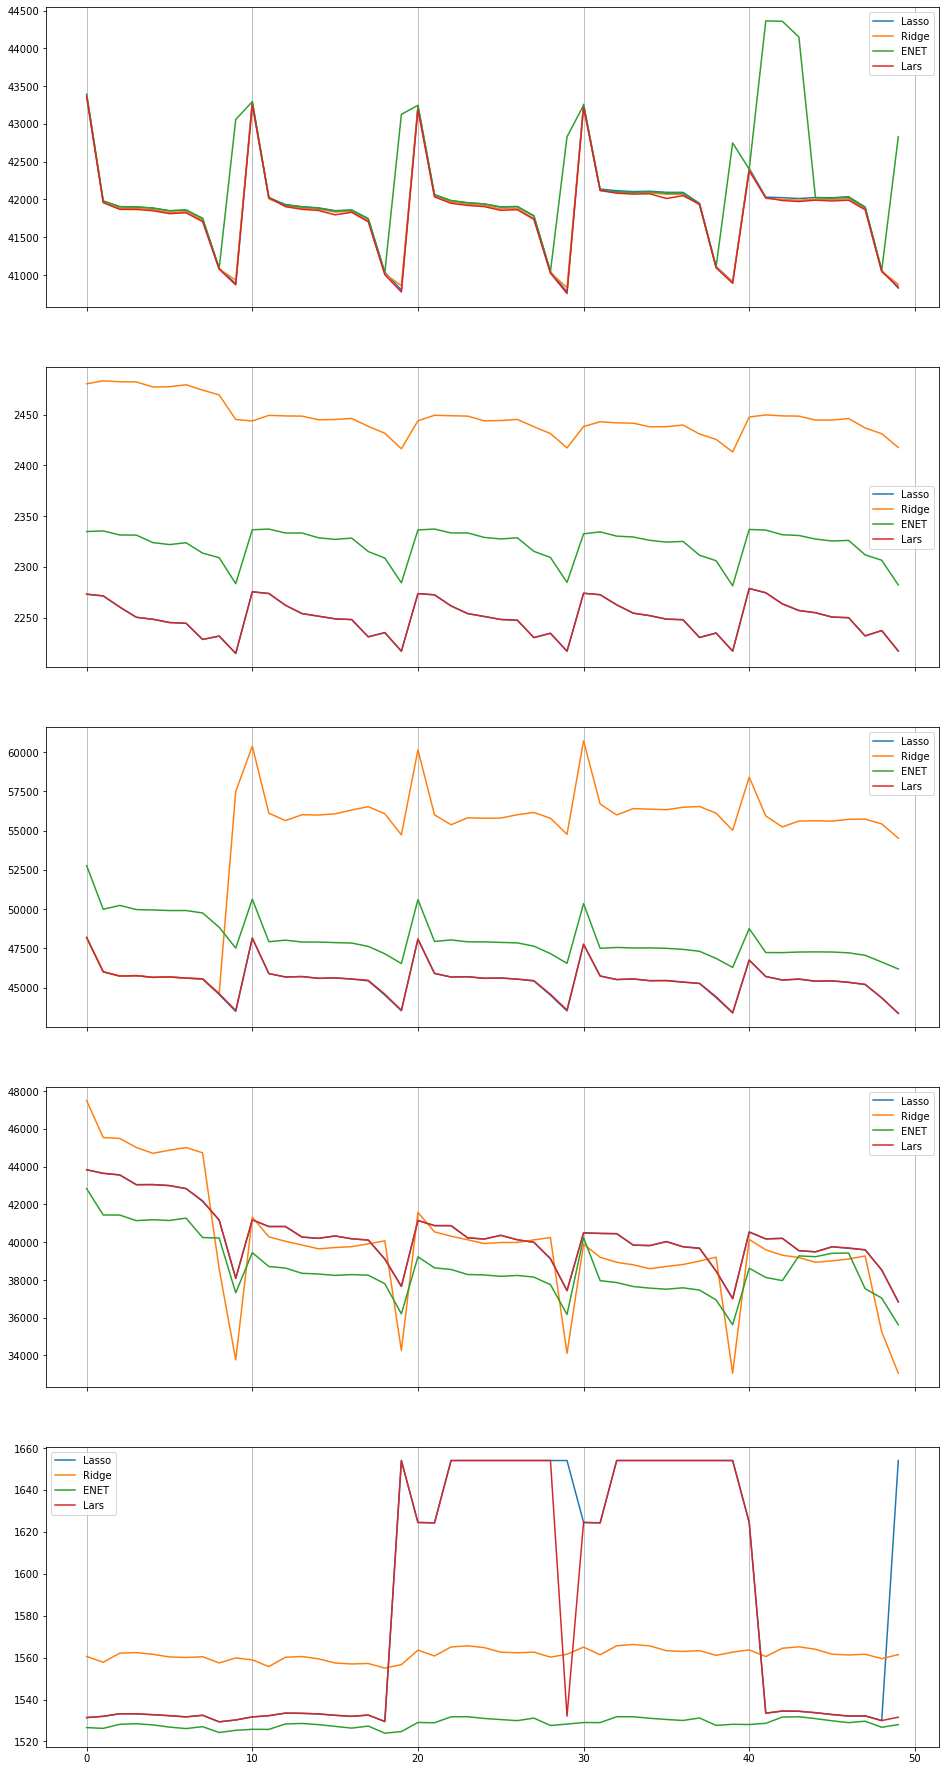

In [17]:
# графики ошибки в зависимости от модели и кол-ва авторегрессионных признаков для каждого кластера
fig, axs = plt.subplots(CLUSTER_NUM, sharex=True, figsize=(16,32))

for c in range(CLUSTER_NUM):
    axs[c].plot(results[c]['0'], label = 'Lasso')
    axs[c].plot(results[c]['1'], label = 'Ridge')
    axs[c].plot(results[c]['2'], label = 'ENET')
    axs[c].plot(results[c]['3'], label = 'Lars')

    axs[c].grid(axis = 'x')
    axs[c].legend()

In [18]:
# оптимальные модели для каждого кластера
best_models = [int(results[c].min().idxmin()) for c in range(CLUSTER_NUM)]

#дублирую, чтобы не запускать каждый раз все ячейки выше
#best_models = [3, 0, 0, 1, 2]
best_models

[3, 0, 3, 1, 2]

In [19]:
# оптимальное кол-во признаков авторегрессии для каждого кластера
best_k_ = [results[c][str(best_models[c])].idxmin() for c in range(CLUSTER_NUM)]
best_k = [[kd_pool[x // 10] , k_pool[x % 10]] for x in best_k_]
#best_k = [[2, 23], [0, 23], [7, 23], [7, 23], [1, 18]]
best_k

[[2, 23], [0, 23], [7, 23], [7, 23], [1, 18]]

In [20]:
# оптимальные параметры модели для каждого кластера
best_params = [grids[c*50+best_k_[c]][best_models[c]].best_params_ for c in range(CLUSTER_NUM)]
'''best_params = [{'alpha': 0.0001, 'normalize': True},
                  {'alpha': 0.0001, 'normalize': True},
                  {'alpha': 0.0001, 'normalize': True},
                  {'alpha': 1.6667333333333334, 'normalize': False},
                  {'alpha': 0.0001, 'normalize': True}]'''
best_params

[{'alpha': 0.0001, 'normalize': True},
 {'alpha': 0.0001, 'normalize': True},
 {'alpha': 0.0001, 'normalize': True},
 {'alpha': 1.6667333333333334, 'normalize': False},
 {'alpha': 0.0001, 'normalize': True}]

In [21]:
# посмотрев на графики выше, можно вручную подобрать меньшее кол-во признаков, которое, однако, почти не ухудшит качество
'''best_k_light = [[0,18],
                [1,23],
                [0,23],
                [5,23],
                [1,18]]
               '''
#В ДАЛЬНЕЙШЕМ НЕ ИСПОЛЬЗУЕТСЯ

'best_k_light = [[0,18],\n                [1,23],\n                [0,23],\n                [5,23],\n                [1,18]]\n               '

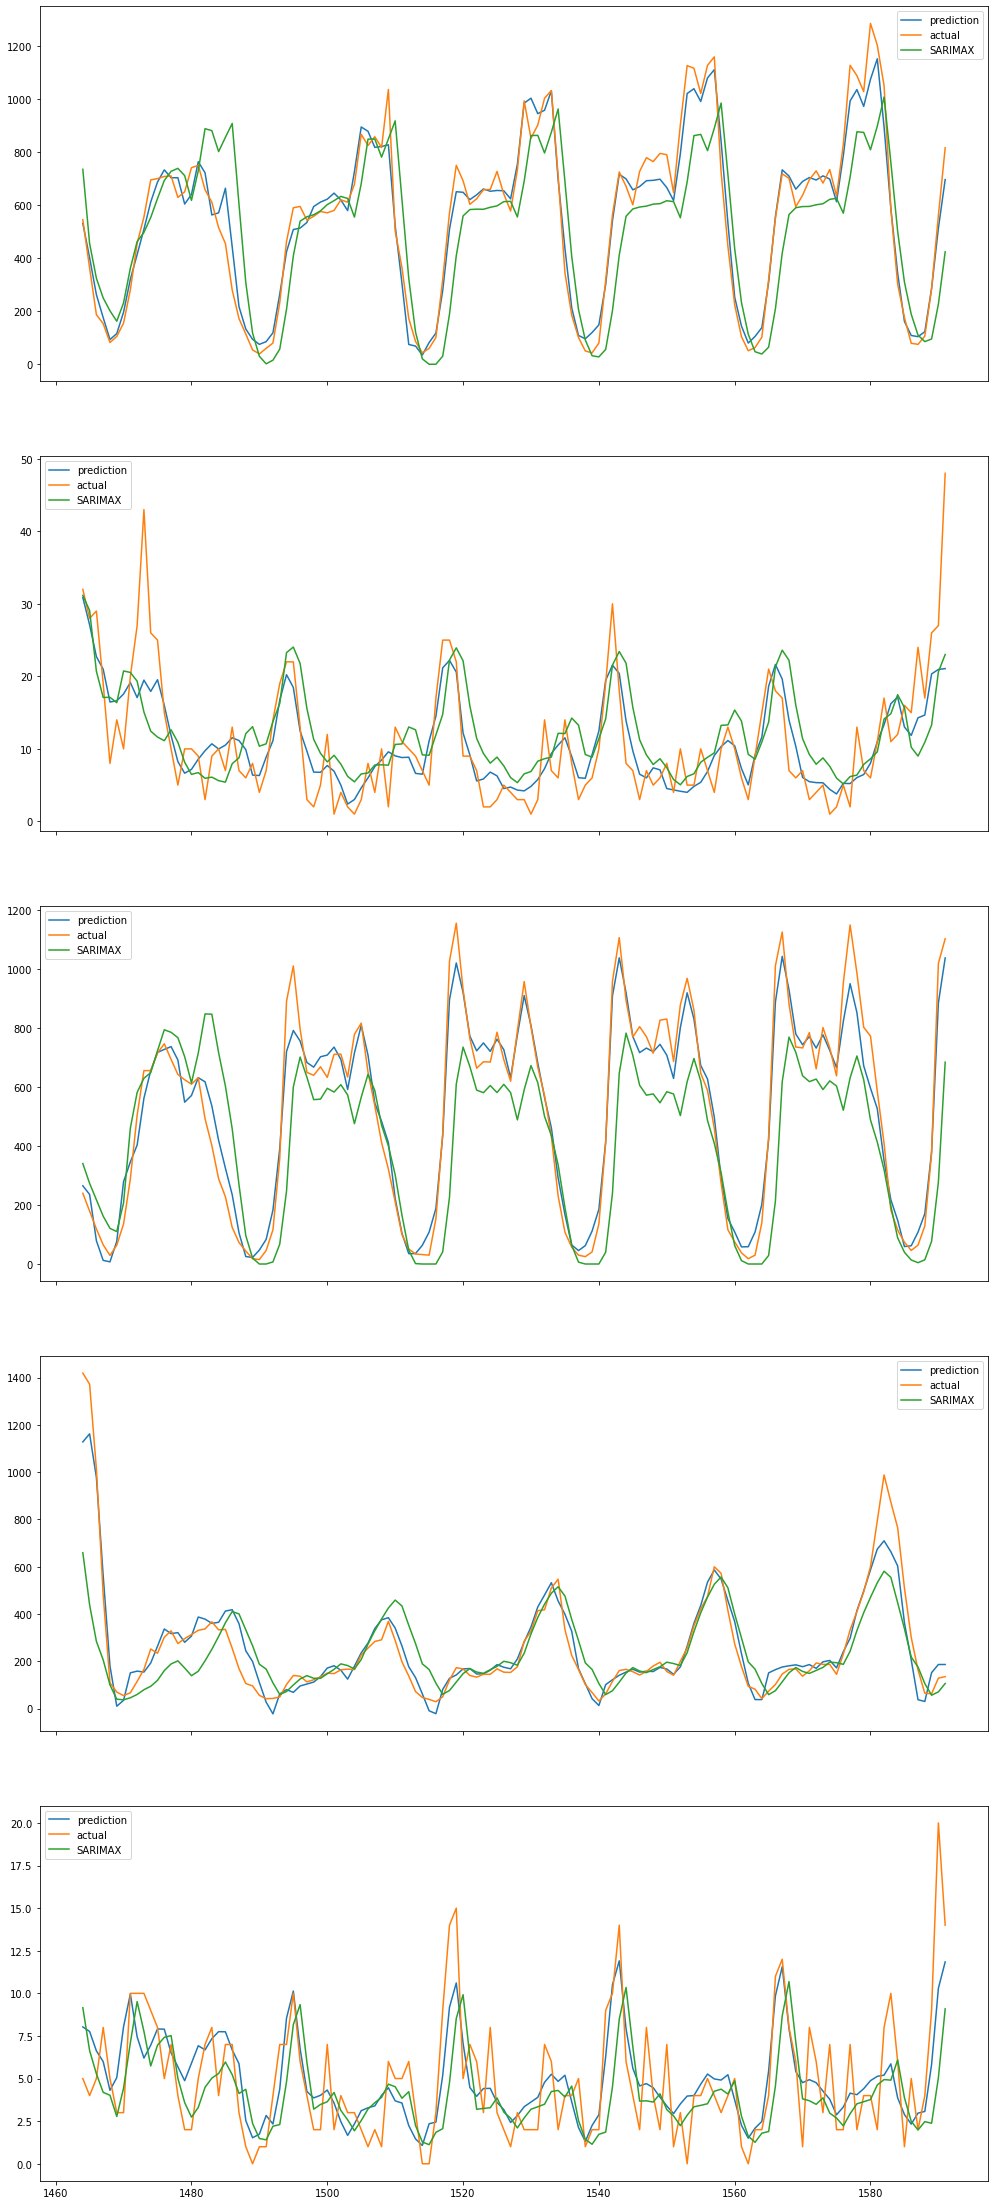

In [22]:
# взглянем на результаты предсказания и сравним с предсказанием SARIMAX из прошлого задания
fig, axs = plt.subplots(CLUSTER_NUM, sharex=True, figsize=(17,40))
PLOT_LEN = 128

for c in range(CLUSTER_NUM):
    model = grids[c*50+best_k_[c]][best_models[c]].best_estimator_
    X,y = extract_feautures(best_k[c][1],best_k[c][0],1,redundant[c])
    X_train, X_test, _ = np.array_split(X, [TT_SPLIT_HOUR,TD_SPLIT_HOUR])
    y_train, y_test, _ = np.array_split(y, [TT_SPLIT_HOUR,TD_SPLIT_HOUR])
    SARIMAX = redundant[c]['SARIMAX'].values

    axs[c].plot(np.arange(TT_SPLIT_HOUR,TD_SPLIT_HOUR)[:PLOT_LEN],model.predict(X_test[:PLOT_LEN]), label = 'prediction')
    axs[c].plot(np.arange(TT_SPLIT_HOUR,TD_SPLIT_HOUR)[:PLOT_LEN],y_test[:PLOT_LEN], label = 'actual')
    axs[c].plot(np.arange(TT_SPLIT_HOUR,TD_SPLIT_HOUR)[:PLOT_LEN],
                SARIMAX[TT_SPLIT_HOUR:TT_SPLIT_HOUR+PLOT_LEN], label = 'SARIMAX')
    axs[c].legend()


Уже по этим графикам видно, что новые модели предсказывают несколько точнее, чем SARIMAX из предыдущего задания

<h3>Вычисление ошибки за май</h3>

In [24]:

models_pool = [lm.Lasso(),lm.Ridge(),lm.ElasticNet(),lm.LassoLars()]
#вспомогательная функция для вычисления ошибки для конкретного региона
def error(region, T_start, T_end, dt_max):
    c = get_cluster(region)
    #Крайние даты начала истории
    T_start = date_to_hour(datetime.datetime.strptime(T_start,'%Y.%m.%d %H:%M'))
    T_end = date_to_hour(datetime.datetime.strptime(T_end,'%Y.%m.%d %H:%M'))
    #Датафрейм с признаками
    reg_data = build_dataset(region,0,T_end+1)
    err = 0 #инициализация ошибки
    # в цикле для каждого dt обучаем модель и считаем ошибку
    for dt in range(1,dt_max+1):
        X,y = extract_feautures(best_k[c][1],best_k[c][0],dt,reg_data)
        X_train, X_test = np.array_split(X, [T_start])
        y_train, y_test = np.array_split(y, [T_start])
        model = models_pool[best_models[c]]
        model.set_params(alpha =best_params[0]['alpha'], normalize = best_params[0]['normalize'])
        model.fit(X_train,y_train)
        err += sum(abs(y_test-model.predict(X_test)))
    return err




In [25]:
from tqdm import tqdm
#Считаем ошибку для каждого кластера
err = 0
for region in tqdm(data.columns):
    err += error(region, '2016.04.30 23:00', '2016.05.31 17:00', 6)
        
err /= 6*739*REGIONS_NUM
print(err)


100%|█████████████████████████████████████████████████████████████████████████████| 102/102 [2:56:35<00:00, 103.88s/it]


27.462195056617123


In [64]:
(33.68-27.46)/33.68*100

18.46793349168646

У модели SARIMAX значение ошибки было 33.68, удалось уменьшить ошибку на 18,5%

<h3>Построение таблицы за июнь</h3>

Строим по аналогии с предыдущей неделей

In [23]:
#построение строки id как требуется в задании
def get_id(region, hour, i):
    date = START + datetime.timedelta(seconds=hour*3600)
    return '{0}_{1}_{2}_{3}'.format(region,date.date(),date.hour, i)                           

#Крайние значания начала истории
T_start = '2016.05.31 23:00' 
T_end = '2016.06.30 17:00'
T_start = date_to_hour(datetime.datetime.strptime(T_start,'%Y.%m.%d %H:%M'))
T_end = date_to_hour(datetime.datetime.strptime(T_end,'%Y.%m.%d %H:%M'))

#Длина прогноза
dt_max = 6

models_pool = [lm.Lasso(),lm.Ridge(),lm.ElasticNet(),lm.LassoLars()]
best_models = [3, 0, 0, 1, 2]
best_k = [[2, 23], [0, 23], [7, 23], [7, 23], [1, 18]]
best_params = [{'alpha': 0.0001, 'normalize': True},
               {'alpha': 0.0001, 'normalize': True},
               {'alpha': 0.0001, 'normalize': True},
               {'alpha': 1.6667333333333334, 'normalize': False},
               {'alpha': 0.0001, 'normalize': True}]
best_k_light = [[0,18],
                [1,23],
                [0,23],
                [5,23],
                [1,18]]

In [24]:
from tqdm import tqdm

ResultTable = pd.DataFrame(columns=['id','y'])# Пустая таблица

for region in tqdm(data.columns): #Цикл по всем регионам
    #Получаем кластер региона, чтобы выбрать модель
    c = get_cluster(region)
    #Датафрейм с признаками
    reg_data = build_dataset(region,0,T_end+dt_max+1)
    # в цикле для каждого dt обучаем модель
    for dt in range(1,dt_max+1):
        #Получаем выборки для данного dt
        X,y = extract_feautures(best_k[c][1],best_k[c][0],dt,reg_data)
        X_train, X_test,_ = np.array_split(X, [T_start,T_end+1])
        y_train, y_test,_ = np.array_split(y, [T_start,T_end+1])
        #Выбираем модель и устанавливаем оптимальные параметры
        model = models_pool[best_models[c]]
        model.set_params(alpha =best_params[0]['alpha'], normalize = best_params[0]['normalize'])
        #Обучаем модель и записываем результат в таблицу
        model.fit(X_train,y_train)
        prediction = model.predict(X_test)
        for i,y in enumerate(prediction):
            new_row = {'id': get_id(region, T_start+i, dt), 'y':y}
            ResultTable = ResultTable.append(new_row, ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 102/102 [5:25:28<00:00, 191.46s/it]


In [27]:
ResultTable.to_csv('week5_result.csv', index=False)

Проверим правильность таблицы. Для этого построим графики предсказаний для произвольеого региона на разные отсчеты и визуально сравним с истинными значениями.

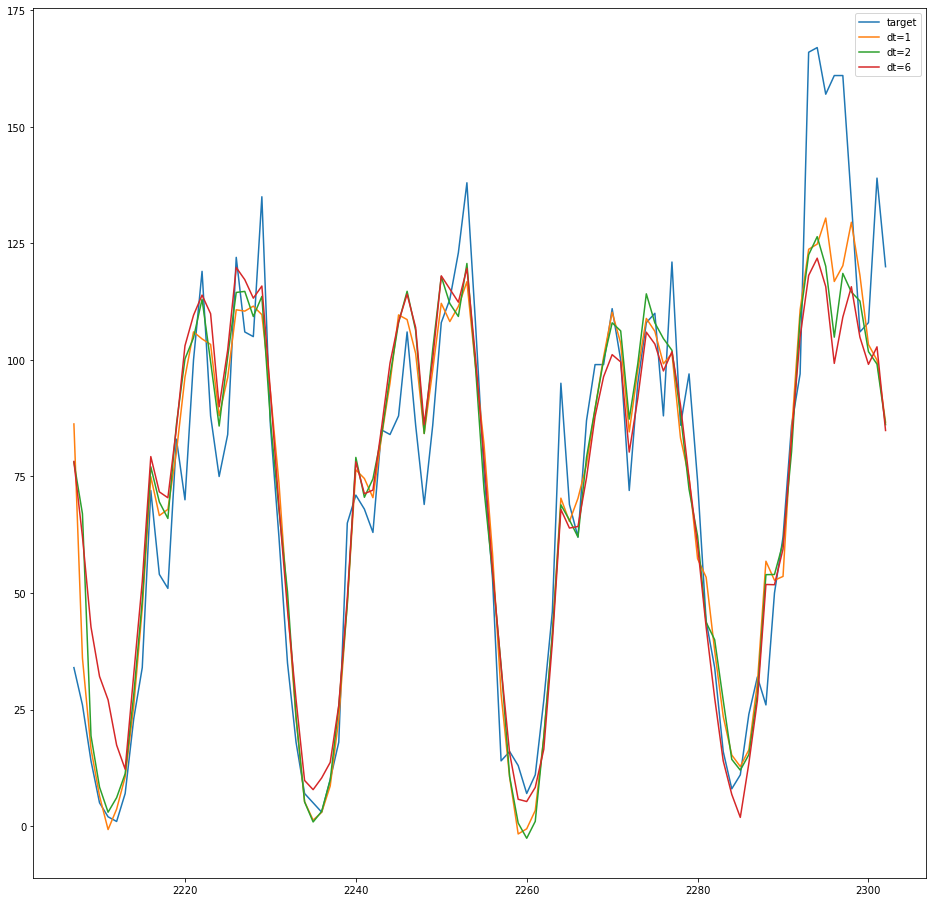

In [71]:
length = T_end-T_start
plt.figure(figsize = (16,16))
plt.plot(np.arange(T_start,T_start+96),data.iloc[T_start:T_start+96,0],label = 'target');
plt.plot(np.arange(T_start,T_start+96),np.roll(ResultTable.iloc[0:96,1],1),label = 'dt=1');
plt.plot(np.arange(T_start,T_start+96),np.roll(ResultTable.iloc[length:length+96,1],2),label = 'dt=2');
plt.plot(np.arange(T_start,T_start+96),np.roll(ResultTable.iloc[5*length:5*length+96,1],6),label = 'dt=6');
plt.legend()

Выглядит адекватно

Ссылка на сабмишн: https://www.kaggle.com/submissions/22328102/22328102.raw
